<a href="https://colab.research.google.com/github/richybu/gis_code/blob/main/assessment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This code was made on google colab as docker would not work on my computer. This was discussed with Dave and he said 
# this would be taken into account when run and marked if there were any issues. 

In [3]:
# import packages:

import os
import numpy as np
import pandas as pd
!pip install geopandas            # use as working in google colab
import geopandas as gpd
import geopandas as gpd   
import matplotlib.cm as cm
import matplotlib.pyplot as plt
!pip install mapclassify          # use as working in google colab
import mapclassify as mc
!pip install legendgram          # use as working in google colab
import legendgram
!pip install pysal          # use as working in google colab
import pysal as p
import palettable.matplotlib as palmpl

In [4]:
import os 
from requests import get
from urllib.parse import urlparse

# define funtion to read datda in

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.

  # i think this function means the file is downloaded to our comp so we dont have to download it from the internet each time
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL   # src is the source url we get the data from? 
    fn  = os.path.split(url.path)[-1] # Extract the filename as filename is the last item in te list i.e. -1
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")
        
        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
        
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [5]:
# we will need the boundaries of the london boroughs. It would also be helpful to see areas of water and park on our final map to make it easier to read,
# and also to make it clear why these areas do not have any listings

ddir  = os.path.join('data','geo') # destination directory (in case it is not found this directory is created)
spath = 'https://github.com/jreades/i2p/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )         # each line makes a geopackage
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

data/geo/Boroughs.gpkg not found, downloading!
	Done downloading...
data/geo/Water.gpkg not found, downloading!
	Done downloading...
data/geo/Greenspace.gpkg not found, downloading!
	Done downloading...
Done.


In [6]:
# check each is a geopackage dataframe
for gpkg in [boros,water,green]:
    print(isinstance(gpkg, gpd.GeoDataFrame))

True
True
True


In [7]:
# check the crs of each
for gpkg in [boros,water,green]:
    print(gpkg.crs)

epsg:27700
epsg:27700
epsg:27700


This will work well for our data - is a common crs for analysing GB data

In [71]:
# print each

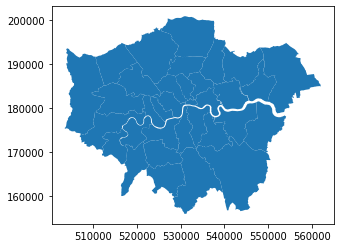

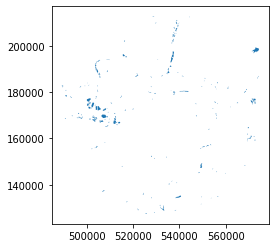

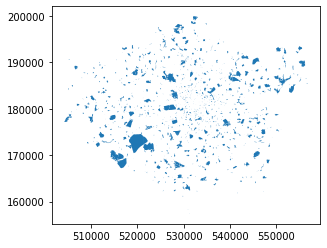

In [8]:
for gpkg in [boros,water,green]:    # a for loop to do a plot of each geopackage
    gpkg.plot()

FileNotFoundError: ignored

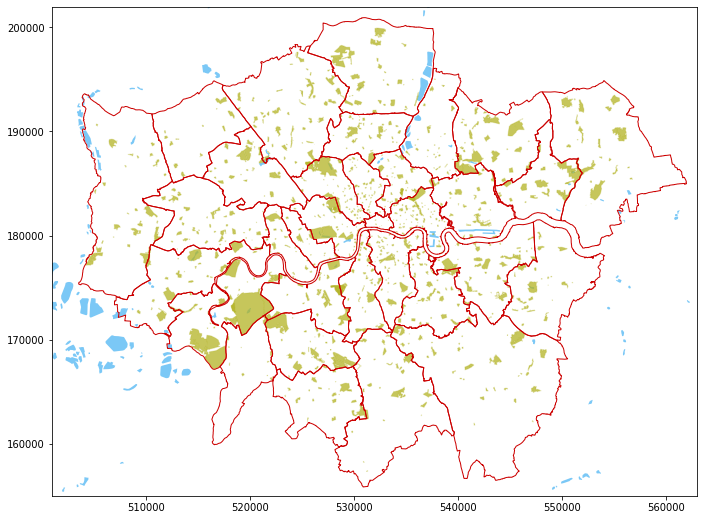

In [9]:
# Plot all three to the same axes and set colours to help show what the areas/lines are
fig, ax = plt.subplots(1,1, figsize=(12,9))

water.plot(edgecolor="none", facecolor='xkcd:lightblue', ax=ax)                         # setting their axis to ax puts them on top of one another
green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14, 0.75), ax=ax)
boros.plot(edgecolor=(0.8, 0, 0, 1), facecolor='none', linewidth=1, ax=ax)

# Set the limits
ax.set_xlim(501000,563000)            # the numbers are the easting and northing values i.e. metres from the equator. They just say how far west, east, north, and south we see on the map. i.e. we only want to see london, not the whole world
ax.set_ylim(155000,202000)

plt.savefig(os.path.join('img','Map-First_Pass.png'))       # saves the figure to img/Map-First_Pass.png

In [10]:
# dont need this section?
# now lets look at our point data
# this uses the London 10 October, 2021 listings.csv.gz file showing the 'Summary information and metrics for listings in London (good for visualisations).' available at http://insideairbnb.com/get-the-data.html

ddir  = os.path.join('data','raw') # destination directory                     
spath = 'https://github.com/richybu/fsds/' # source path

# pdf is pandas dataframe
pdf = pd.read_csv( cache_data(spath+'listings5.csv?raw=true', ddir),
    low_memory=False)



data/raw/listings5.csv not found, downloading!
	Done downloading...


In [11]:
# free up some memory
del(pdf)

In [13]:
# set the columns we want and load the airbnb data
cols = ['id','latitude','longitude', 'host_total_listings_count', 'host_id']
ddir  = os.path.join('data','raw')                     
spath = 'https://raw.githubusercontent.com/richybu/fsds/master/listings5.csv' 
pdf  = pd.read_csv( cache_data(spath, ddir),
        low_memory=False, usecols=cols)

print(f"pdf now contains {pdf.shape[0]} rows.")
pdf.info()

data/raw/listings5.csv not found, downloading!
	Done downloading...
pdf now contains 67903 rows.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67903 entries, 0 to 67902
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         67903 non-null  int64  
 1   host_id                    67903 non-null  int64  
 2   host_total_listings_count  67871 non-null  float64
 3   latitude                   67903 non-null  float64
 4   longitude                  67903 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 2.6 MB


In [ ]:
# the downloaded gz file is too big, a rezipped file is too big. tried .zip a smaller file but i get the error, so could try gz reduced file using terminal?

In [ ]:
# host_total_listings_count, latitude, and longitude are the correct datatypes for what were going to do with them

In [14]:
# drop the rows that have a value of '0' in the 'host_total_listings_count' column
# drop the rows that have a value of '1' as we only want to show listings whose host has another listing

pdf = pdf[pdf.host_total_listings_count != 0]
pdf = pdf[pdf.host_total_listings_count != 1]

print(f"pdf now contains {pdf.shape[0]} rows.")


# or for 0 values use the drop na values as outlined in example?




pdf now contains 29462 rows.


In [15]:
# drop the rows where lat and long have null values

pdf.drop(pdf[pdf.latitude.isna()].index.values, axis=0, inplace=True)
pdf.drop(pdf[pdf.longitude.isna()].index.values, axis=0, inplace=True)
print(f"pdf now contains {pdf.shape[0]} rows.")

pdf now contains 29462 rows.


In [16]:
# find the min/max longitude and latitudes to set the bounding box

print(f"The bottom-left corner is {pdf.longitude.min()}, {pdf.latitude.min()}")     # checks the min and max long and lat so we can figure out what the bounding box is i.e. where the edges of the map will be
print(f"The top-right corner is {pdf.longitude.max()}, {pdf.latitude.max()}")

The bottom-left corner is -0.48933000000000004, 51.297709999999995
The top-right corner is 0.28563, 51.6763


In [17]:
# change the coordinates to geodata, and set the cooridnate reference system
gdf = gpd.GeoDataFrame(pdf,                   
      geometry=gpd.points_from_xy(pdf['longitude'], pdf['latitude'], crs='epsg:4326'))


In [18]:
# check the data types
print(type(gdf))
print(type(gdf.geometry))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>


In [19]:
# save the geodataframe to the directory:
boros.to_file('test.gpkg', driver='GPKG')

epsg:4326
[-0.48933 51.29771  0.28563 51.6763 ]


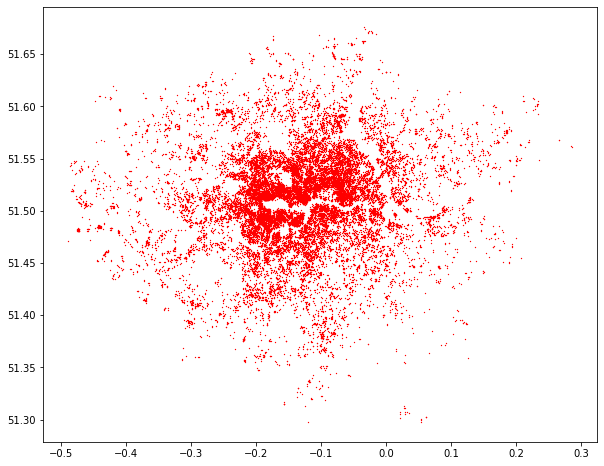

In [20]:
# print the airbnb data in its original crs

print(gdf.geometry.crs)     # prints the crs
print(gdf.total_bounds)     # prints the x and y cooridnates of the edges of the map i.e. the bounding box 
gdf.plot(figsize=(12,8), marker='*', color='red', markersize=0.2)

epsg:27700
[505022.6942146  157075.60491012 558530.54297458 199332.91453931]


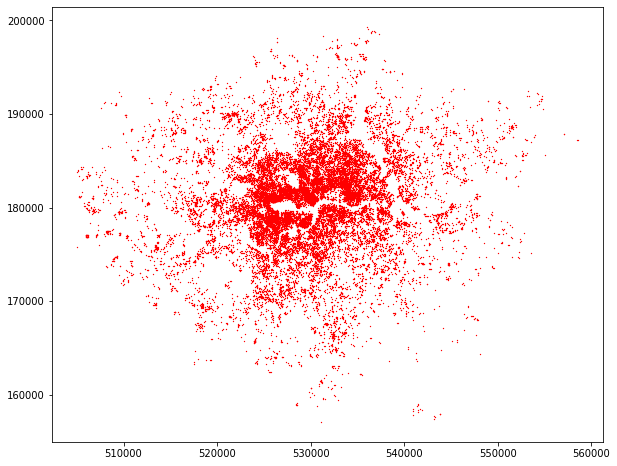

In [21]:
gdf = gdf.to_crs("epsg:27700")      # change the crs
print(gdf.geometry.crs)             # print the crs
print(gdf.total_bounds)             # pirnt the bounding box
gdf.plot(figsize=(12,8), marker='*', color='red', markersize=0.2)     # print with our new crs

In [22]:
print(f"The range of host_total_listings_count is {gdf.host_total_listings_count.min():,.2f} to {gdf.host_total_listings_count.max():,.2f}")      
print(f"The mean and median of the host_total_listings_count are {gdf.host_total_listings_count.mean():,.2f} and {gdf.host_total_listings_count.median():,.2f}")

The range of host_total_listings_count is 2.00 to 3,508.00
The mean and median of the host_total_listings_count are 105.99 and 4.00


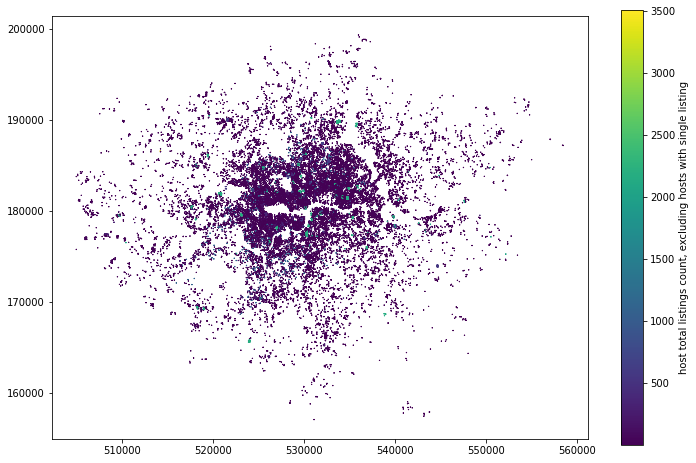

In [23]:
gdf.plot(figsize=(12,8), marker='*', markersize=0.25,
         column='host_total_listings_count', cmap='viridis', 
         legend=True, legend_kwds={'label':'host total listings count, excluding hosts with single listing'})

In [ ]:
# wow thats a lot of listings that have a host with other listing(s)!
# once removed out liers check if should make another map with lower listings count removed so can see just the higher listing counts?

(168954.0, 188175.0)

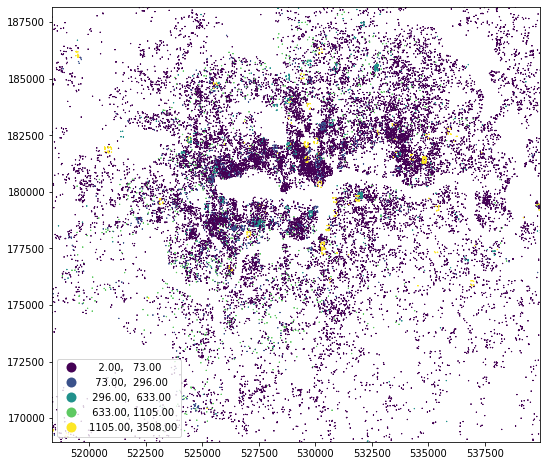

In [24]:
# plot all multi-listings
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='host_total_listings_count', cmap='viridis', scheme='fisher_jenks', k=5, 
         legend=True)
ax.set_xlim([518369,539946])
ax.set_ylim([168954,188175])
# justify these ranges

(168954.0, 188175.0)

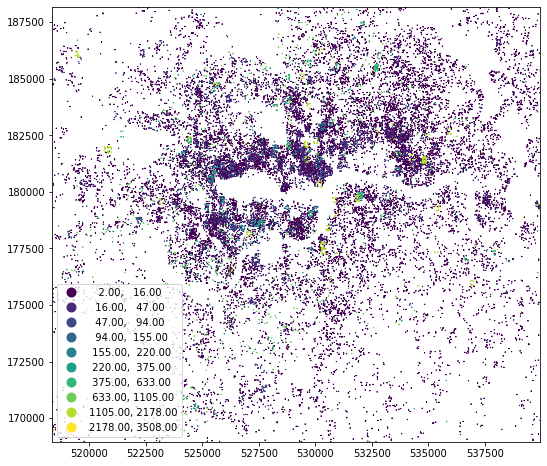

In [25]:
# try with a higher k value to make lower bands more distinctive, but it does not become much clearer
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='host_total_listings_count', cmap='viridis', scheme='fisher_jenks', k=10, 
         legend=True)
ax.set_xlim([518369,539946])
ax.set_ylim([168954,188175])

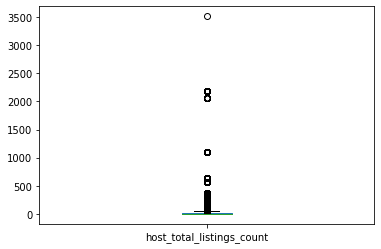

In [26]:
# box plot to see spread of data

gdf.host_total_listings_count.plot.box()  

In [ ]:
# cant remove 'outliers' as some of them are the worst offenders and so contain useful data e.g. 1105. So not point in taking a log of host_total_listings_count
# 'outliers' will mean majority of points on a chloropleth map are within a similar range (i.e. all coloured purple on map above) and so difficult to see colour diffentiation on the map
# on plot above most values look to be below 500
# so can plot a map of values above 500 to show mayor where SUPER hosts are
# and plot a map with values below 500 to get a visual of more casual professionalisation 

In [27]:
# create a column of the log of the host total listings
gdf['lnhost_total_listings_count'] = np.log2(gdf['host_total_listings_count'])

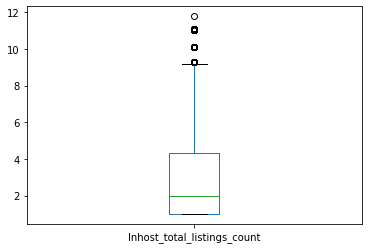

In [28]:

gdf.lnhost_total_listings_count.plot.box() 

In [29]:
# find how many unique host_total_listings_count values there are to help us decide the number of bins for a histogram
print(gdf.host_total_listings_count.nunique())

100


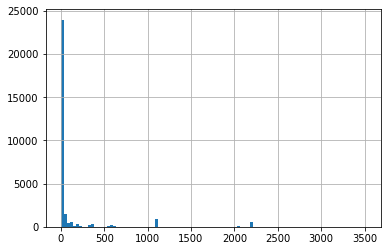

In [30]:
hist = gdf.host_total_listings_count.hist(bins=100)

In [32]:
# create a datafram of the values less than 500 fo a clearer look at lower values
gdflessthan500 = gdf[gdf.host_total_listings_count <= 500]

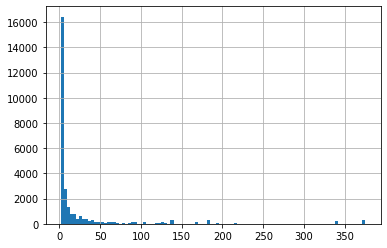

In [33]:
hist = gdflessthan500.host_total_listings_count.hist(bins=100)

In [34]:
# create a datafram of the values less than 20
gdflessthan20 = gdf[gdf.host_total_listings_count <= 20]

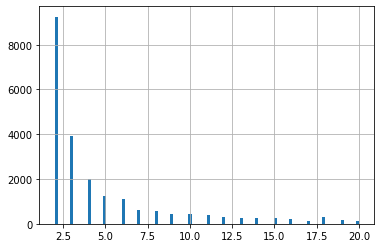

In [35]:
st = gdflessthan20.host_total_listings_count.hist(bins=100)

In [43]:
def plot_points(ranges):
  ax = ranges.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='host_total_listings_count', cmap='viridis', scheme='fisher_jenks', k=5,
         legend=True)
  ax.set_xlim([525000,535000])
  ax.set_ylim([178000,185000])

for ranges in [gdflessthan20,gdfgreaterthan20,gdfgreaterthan100]:
  ranges.plot_points()

AttributeError: ignored

(168954.0, 188175.0)

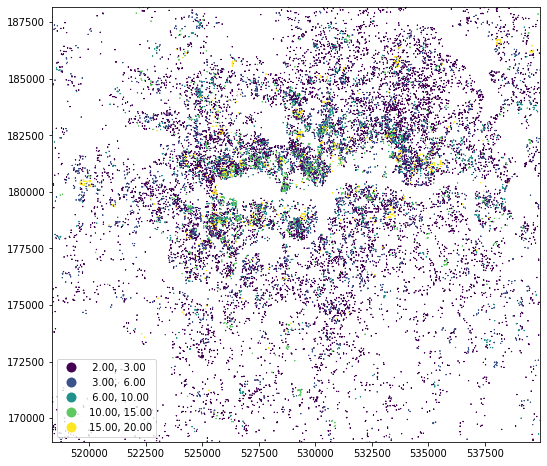

In [38]:
ax = gdflessthan20.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='host_total_listings_count', cmap='viridis', scheme='fisher_jenks', k=5,
         legend=True)
ax.set_xlim([518369,539946])
ax.set_ylim([168954,188175])

In [39]:
gdfgreaterthan20 = gdf[gdf.host_total_listings_count >= 20]
gdfbetween20and100 = gdfgreaterthan20[gdfgreaterthan20.host_total_listings_count <= 100]

(168954.0, 188175.0)

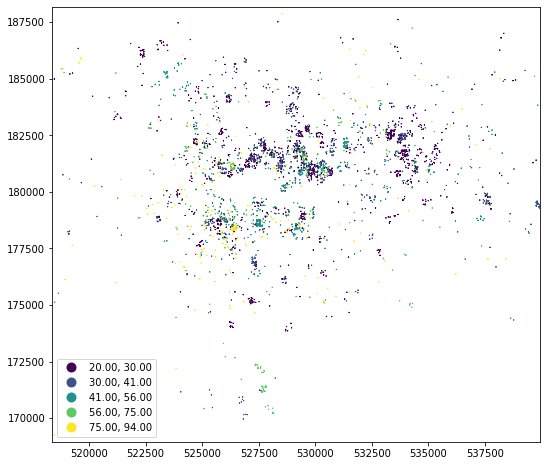

In [40]:
ax = gdfbetween20and100.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='host_total_listings_count', cmap='viridis', scheme='fisher_jenks', k=5, 
         legend=True)
ax.set_xlim([518369,539946])
ax.set_ylim([168954,188175])

In [42]:
gdfgreaterthan100 = gdf[gdf.host_total_listings_count >= 100]

(168954.0, 188175.0)

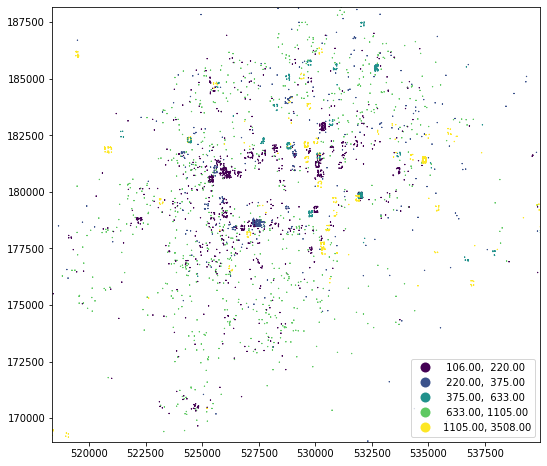

In [44]:
# using fisher jenks to optimise classes so worst offenders are clearer
# also comapre with non fisher jenks to check which is clearer?
ax = gdfgreaterthan100.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='host_total_listings_count', cmap='viridis', scheme='fisher_jenks', k=5, 
         legend=True)
ax.set_xlim([518369,539946])
ax.set_ylim([168954,188175])

# same colours in similar locations mean you can guess that theyre owned by the same host?
# could then go on to do cluster analysis to show clusters in certain boroughs?

In [ ]:

# could use the above map to find the worst offenders?

In [45]:
def plot_on_map(ranges):
  q = mc.Quantiles(gdflessthan20.host_total_listings_count.values, k=5) # For Fisher Jenks you may want 'Sampled' to speed things up

  f,ax = plt.subplots(figsize=(15,9))     # two values outputted, one is for f, one is for ax (the axis of the graph)
  water.plot(edgecolor="none", facecolor='xkcd:lightblue', ax=ax)
  green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14), ax=ax)
  gdflessthan20.plot(column='host_total_listings_count', scheme='Quantiles', k=5, 
         cmap='viridis', legend=True, marker='*', markersize=0.5, ax=ax)
  boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, ax=ax)

  ax.set_xlim([525000,540000])
  ax.set_ylim([176000,186000])
  ax.axis('off') #don't plot the axes (bounding box)
  ax.set_title('London Airbnb Listings Listed By Hosts With Multiple Listings', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title
  a = ax.annotate('Source: InsideAirbnb (2020)',
              xy=(0.905, 0.055), xycoords='figure fraction', 
               horizontalalignment='right', verticalalignment='bottom', 
               fontsize=12, fontweight=4, color='#555555')  #add source info on the image itself
  a.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))
  ax.get_legend().set_title("Number of Listings of Host")  #set the legend title

  legendgram(f, ax, 
              gdflessthan20.host_total_listings_count, q.bins, bins=round(gdflessthan20.host_total_listings_count.max()/25),
              pal=palmpl.Viridis_5,
              legend_size=(0.3, 0.1), 
              loc='lower left',
              clip=(0,750),
              frameon=True
      )

  f.savefig('ppn.png', dpi=150)

for ranges in [gdflessthan20,gdfgreaterthan20,gdfgreaterthan100]:
  ranges.plot_on_map()


AttributeError: ignored

/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


TypeError: ignored

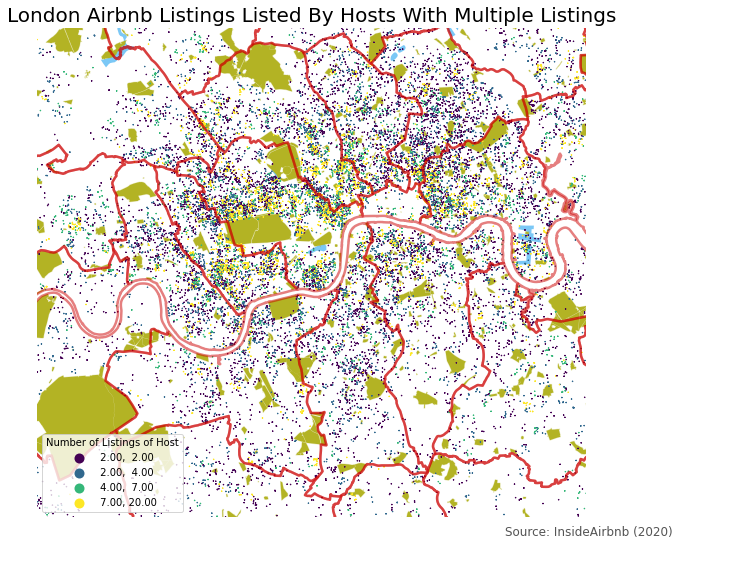

In [48]:
q = mc.Quantiles(gdflessthan20.host_total_listings_count.values, k=5) # For Fisher Jenks you may want 'Sampled' to speed things up

f,ax = plt.subplots(figsize=(15,9))     # two values outputted, one is for f, one is for ax (the axis of the graph)
water.plot(edgecolor="none", facecolor='xkcd:lightblue', ax=ax)
green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14), ax=ax)
gdflessthan20.plot(column='host_total_listings_count', scheme='Quantiles', k=5, 
         cmap='viridis', legend=True, marker='*', markersize=0.5, ax=ax)
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, ax=ax)

#ax.set_xlim([525000,540000])
#ax.set_ylim([176000,186000])
ax.set_xlim([518369,539946])
ax.set_ylim([168954,188175])
ax.axis('off') #don't plot the axes (bounding box)
ax.set_title('London Airbnb Listings Listed By Hosts With Multiple Listings', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title
a = ax.annotate('Source: InsideAirbnb (2020)',
             xy=(0.905, 0.055), xycoords='figure fraction', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=12, fontweight=4, color='#555555')  #add source info on the image itself
a.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))
ax.get_legend().set_title("Number of Listings of Host")  #set the legend title

legendgram(f, ax, 
            gdflessthan20.host_total_listings_count, q.bins, bins=round(gdflessthan20.host_total_listings_count.max()/25),
            pal=palmpl.Viridis_5,
            legend_size=(0.3, 0.1), 
            loc='lower left',
            clip=(0,750),
            frameon=True
    )

f.savefig('ppn.png', dpi=150)

TypeError: ignored

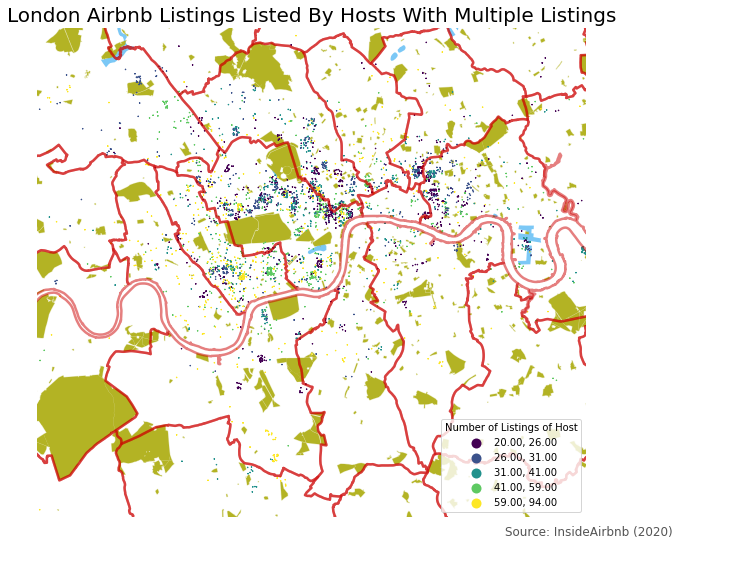

In [49]:
q = mc.Quantiles(gdfbetween20and100.host_total_listings_count.values, k=5) # For Fisher Jenks you may want 'Sampled' to speed things up

f,ax = plt.subplots(figsize=(15,9))     # two values outputted, one is for f, one is for ax (the axis of the graph)
water.plot(edgecolor="none", facecolor='xkcd:lightblue', ax=ax)
green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14), ax=ax)
gdfbetween20and100.plot(column='host_total_listings_count', scheme='Quantiles', k=5, 
         cmap='viridis', legend=True, marker='*', markersize=0.5, ax=ax)
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, ax=ax)

#ax.set_xlim([525000,540000])
#ax.set_ylim([176000,186000])
ax.set_xlim([518369,539946])
ax.set_ylim([168954,188175])
ax.axis('off') #don't plot the axes (bounding box)
ax.set_title('London Airbnb Listings Listed By Hosts With Multiple Listings', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title
a = ax.annotate('Source: InsideAirbnb (2020)',
             xy=(0.905, 0.055), xycoords='figure fraction', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=12, fontweight=4, color='#555555')  #add source info on the image itself
a.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))
ax.get_legend().set_title("Number of Listings of Host")  #set the legend title

legendgram(f, ax, 
            gdfbetween20and100.host_total_listings_count, q.bins, bins=round(gdfbetween20and100.host_total_listings_count.max()/25),
            pal=palmpl.Viridis_5,
            legend_size=(0.3, 0.1), 
            loc='lower left',
            clip=(0,750),
            frameon=True
    )

f.savefig('ppn.png', dpi=150)

In [ ]:
# maybe they are errors? More investigation needed

TypeError: ignored

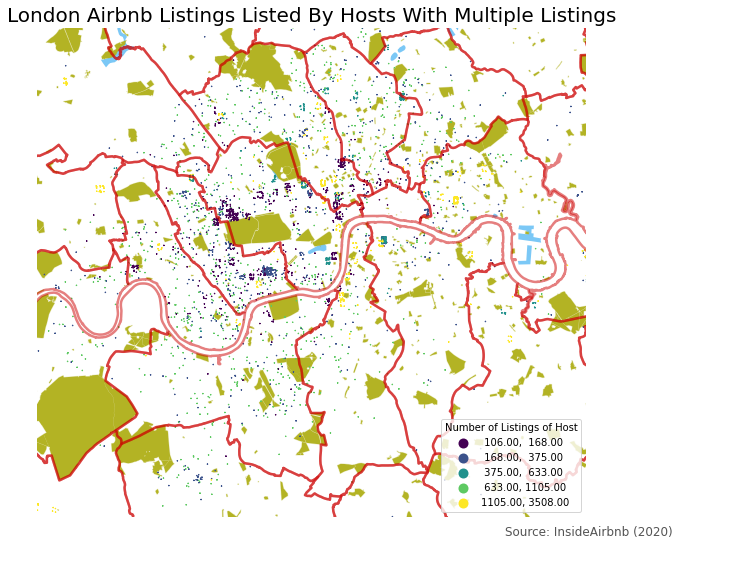

In [50]:
q = mc.Quantiles(gdfgreaterthan100.host_total_listings_count.values, k=5) # For Fisher Jenks you may want 'Sampled' to speed things up

f,ax = plt.subplots(figsize=(15,9))     # two values outputted, one is for f, one is for ax (the axis of the graph)
water.plot(edgecolor="none", facecolor='xkcd:lightblue', ax=ax)
green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14), ax=ax)
gdfgreaterthan100.plot(column='host_total_listings_count', scheme='Quantiles', k=5, 
         cmap='viridis', legend=True, marker='*', markersize=0.5, ax=ax)
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, ax=ax)

#ax.set_xlim([525000,540000])
#ax.set_ylim([176000,186000])
ax.set_xlim([518369,539946])
ax.set_ylim([168954,188175])
ax.axis('off') #don't plot the axes (bounding box)
ax.set_title('London Airbnb Listings Listed By Hosts With Multiple Listings', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title
a = ax.annotate('Source: InsideAirbnb (2020)',
             xy=(0.905, 0.055), xycoords='figure fraction', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=12, fontweight=4, color='#555555')  #add source info on the image itself
a.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))
ax.get_legend().set_title("Number of Listings of Host")  #set the legend title

legendgram(f, ax, 
            gdfgreaterthan100.host_total_listings_count, q.bins, bins=round(gdfgreaterthan100.host_total_listings_count.max()/25),
            pal=palmpl.Viridis_5,
            legend_size=(0.3, 0.1), 
            loc='lower left',
            clip=(0,750),
            frameon=True
    )

f.savefig('ppn.png', dpi=150)

TypeError: ignored

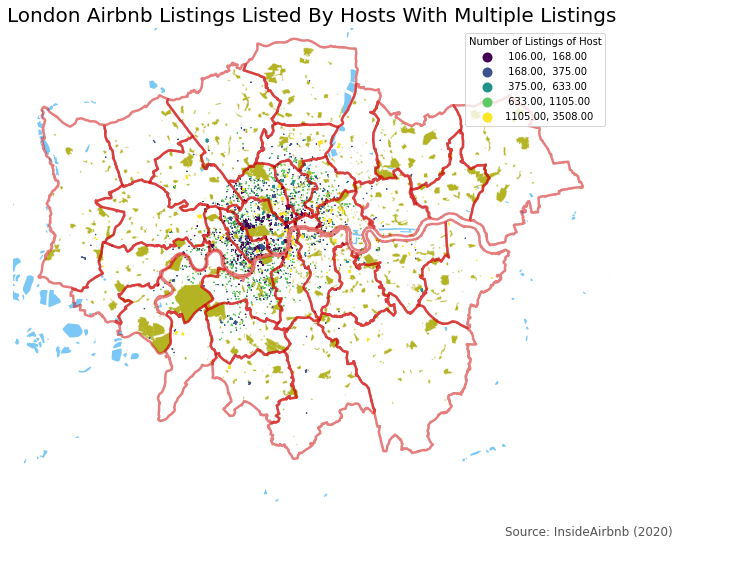

In [51]:
q = mc.Quantiles(gdfgreaterthan100.host_total_listings_count.values, k=5) # For Fisher Jenks you may want 'Sampled' to speed things up

f,ax = plt.subplots(figsize=(15,9))     # two values outputted, one is for f, one is for ax (the axis of the graph)
water.plot(edgecolor="none", facecolor='xkcd:lightblue', ax=ax)
green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14), ax=ax)
gdfgreaterthan100.plot(column='host_total_listings_count', scheme='Quantiles', k=5, 
         cmap='viridis', legend=True, marker='*', markersize=0.5, ax=ax)
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, ax=ax)

ax.set_xlim([500864,564931])
ax.set_ylim([149562,202073])
ax.axis('off') #don't plot the axes (bounding box)
ax.set_title('London Airbnb Listings Listed By Hosts With Multiple Listings', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title
a = ax.annotate('Source: InsideAirbnb (2020)',
             xy=(0.905, 0.055), xycoords='figure fraction', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=12, fontweight=4, color='#555555')  #add source info on the image itself
a.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))
ax.get_legend().set_title("Number of Listings of Host")  #set the legend title

legendgram(f, ax, 
            gdfgreaterthan100.host_total_listings_count, q.bins, bins=round(gdfgreaterthan100.host_total_listings_count.max()/25),
            pal=palmpl.Viridis_5,
            legend_size=(0.3, 0.1), 
            loc='lower left',
            clip=(0,750),
            frameon=True
    )

f.savefig('ppn.png', dpi=150)

TypeError: ignored

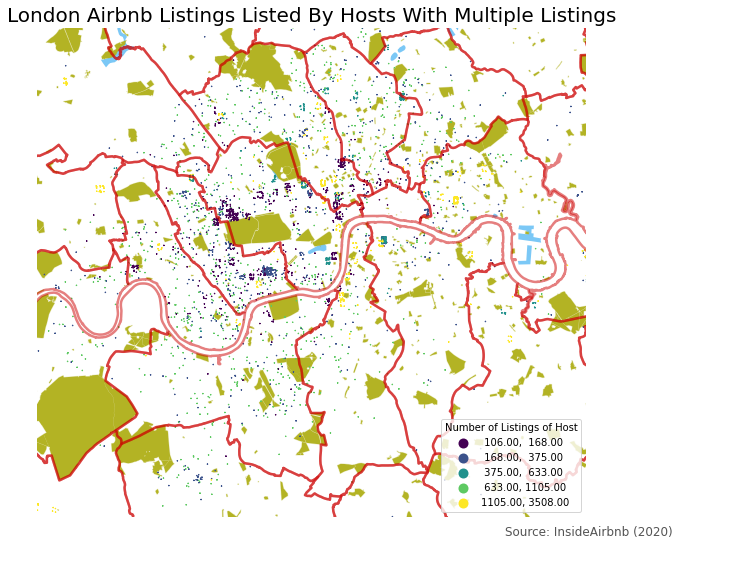

In [52]:
q = mc.Quantiles(gdfgreaterthan100.host_total_listings_count.values, k=5) # For Fisher Jenks you may want 'Sampled' to speed things up

f,ax = plt.subplots(figsize=(15,9))     # two values outputted, one is for f, one is for ax (the axis of the graph)
water.plot(edgecolor="none", facecolor='xkcd:lightblue', ax=ax)
green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14), ax=ax)
gdfgreaterthan100.plot(column='host_total_listings_count', scheme='Quantiles', k=5, 
         cmap='viridis', legend=True, marker='*', markersize=0.5, ax=ax)
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, ax=ax)

ax.set_xlim([518369,539946])
ax.set_ylim([168954,188175])
ax.axis('off') #don't plot the axes (bounding box)
ax.set_title('London Airbnb Listings Listed By Hosts With Multiple Listings', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title
a = ax.annotate('Source: InsideAirbnb (2020)',
             xy=(0.905, 0.055), xycoords='figure fraction', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=12, fontweight=4, color='#555555')  #add source info on the image itself
a.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))
ax.get_legend().set_title("Number of Listings of Host")  #set the legend title

legendgram(f, ax, 
            gdfgreaterthan100.host_total_listings_count, q.bins, bins=round(gdfgreaterthan100.host_total_listings_count.max()/25),
            pal=palmpl.Viridis_5,
            legend_size=(0.3, 0.1), 
            loc='lower left',
            clip=(0,750),
            frameon=True
    )

f.savefig('ppn.png', dpi=150)

TypeError: ignored

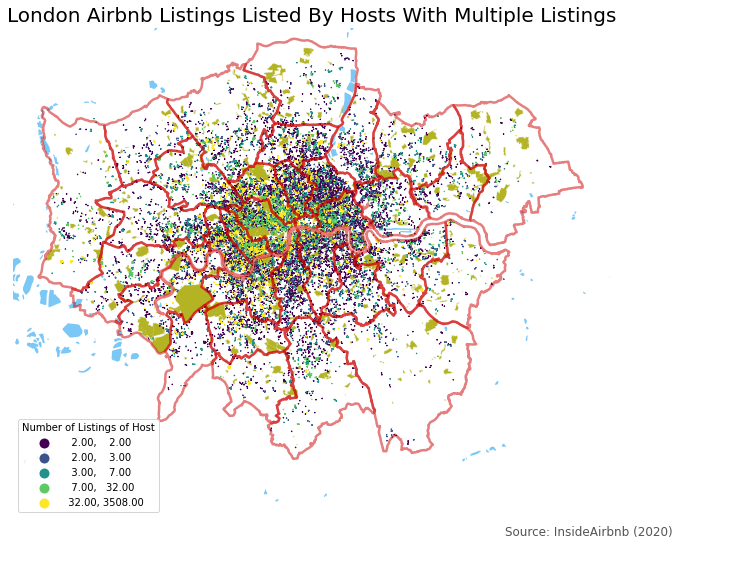

In [54]:
q = mc.Quantiles(gdf.host_total_listings_count.values, k=5) # For Fisher Jenks you may want 'Sampled' to speed things up

f,ax = plt.subplots(figsize=(15,9))     # two values outputted, one is for f, one is for ax (the axis of the graph)
water.plot(edgecolor="none", facecolor='xkcd:lightblue', ax=ax)
green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14), ax=ax)
gdf.plot(column='host_total_listings_count', scheme='Quantiles', k=5, 
         cmap='viridis', legend=True, marker='*', markersize=0.5, ax=ax)
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, ax=ax)

ax.set_xlim([500864,564931])
ax.set_ylim([149562,202073])
ax.axis('off') #don't plot the axes (bounding box)
ax.set_title('London Airbnb Listings Listed By Hosts With Multiple Listings', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title
a = ax.annotate('Source: InsideAirbnb (2020)',
             xy=(0.905, 0.055), xycoords='figure fraction', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=12, fontweight=4, color='#555555')  #add source info on the image itself
a.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))
ax.get_legend().set_title("Number of Listings of Host")  #set the legend title

legendgram(f, ax, 
            gdf.host_total_listings_count, q.bins, bins=round(gdf.host_total_listings_count.max()/25),
            pal=palmpl.Viridis_5,
            legend_size=(0.3, 0.1), 
            loc='lower left',
            clip=(0,750),
            frameon=True
    )

f.savefig('ppn.png', dpi=150)